In [1]:
#!pip install yahoo_finance_api2

In [2]:
import pandas as pd
import sys
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError
from datetime import datetime

def dataloader(stock_name):
    my_share = share.Share(stock_name)
    symbol_data = None

    try:
        symbol_data = my_share.get_historical(share.PERIOD_TYPE_YEAR,30,
                                            share.FREQUENCY_TYPE_DAY,1)
        print(stock_name+" has been downloaded")

    except YahooFinanceError as e:
        print(e.message)
        sys.exit(1)
        
    df = pd.DataFrame(symbol_data)

    df['timestamp'] = [datetime.fromtimestamp(t/1000) for t in df['timestamp']]

    # test = df[(df['timestamp'] >= '2016-1-1 01:00:00') & (df['timestamp'] <= '2018-12-31 04:00:00')]
    return df[(df['timestamp'] >= '1995-01-01 01:00:00') & (df['timestamp'] <= '2018-12-31 04:00:00')]

print(dataloader("AAPL"))

AAPL has been downloaded
               timestamp        open        high         low       close  \
1280 1995-01-03 09:30:00    1.388393    1.388393    1.352679    1.370536   
1281 1995-01-04 09:30:00    1.379464    1.415179    1.379464    1.406250   
1282 1995-01-05 09:30:00    1.401786    1.406250    1.383929    1.388393   
1283 1995-01-06 09:30:00    1.486607    1.540179    1.468750    1.500000   
1284 1995-01-09 09:30:00    1.486607    1.495536    1.464286    1.471540   
...                  ...         ...         ...         ...         ...   
7316 2018-12-21 09:30:00  156.860001  158.160004  149.630005  150.729996   
7317 2018-12-24 09:30:00  148.149994  151.550003  146.589996  146.830002   
7318 2018-12-26 09:30:00  148.300003  157.229996  146.720001  157.169998   
7319 2018-12-27 09:30:00  155.839996  156.770004  150.070007  156.149994   
7320 2018-12-28 09:30:00  157.500000  158.520004  154.550003  156.229996   

         volume  
1280   25967200  
1281   39670400  
1282   1

In [23]:
import numpy as np
import math

def get_data(stock_name):
    train = []
    test = []
    
    for name in stock_name:
        df = dataloader(name)
        train.append( list(df[(df['timestamp'] >= '1995-01-01 01:00:00') & (df['timestamp'] <= '2015-12-31 04:00:00')]['close']) )
        test.append( list(df[(df['timestamp'] >= '2016-01-01 01:00:00') & (df['timestamp'] <= '2017-12-31 12:00:00')]['close']) )

    return train, test

AAPL has been downloaded


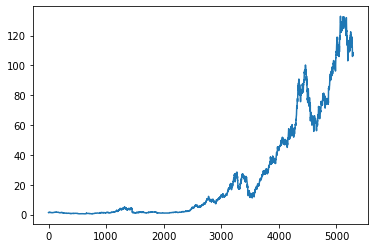

In [7]:
import matplotlib.pyplot as plt

train_data,_ = get_data(["AAPL"])

plt.plot([i for i in range(len(train_data))], train_data)
plt.show()

In [62]:
import keras
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import AveragePooling1D

from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Add
from keras.layers import Concatenate
from keras.layers import GaussianNoise
from keras.layers import LSTM

from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import SGD
import keras.backend as K
from keras.utils.vis_utils import plot_model

def Res_model():
  
    x_input = Input(shape=(20,1,))

    x = GaussianNoise(stddev=10)(x_input)
    y = Conv1D(filters=20, kernel_size=3, activation='tanh')(x)
    y = Conv1D(filters=20, kernel_size=3, activation='relu')(y)
    y = MaxPooling1D(pool_size=2)(y)
    y = Dropout(0.2)(y)

    x = Conv1D(filters=20, kernel_size=3, activation=None)(x)
    x = Conv1D(filters=20, kernel_size=3, activation=None)(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Add()([x,y])

    y = Conv1D(filters=20, kernel_size=3, activation='tanh')(x)
    y = Conv1D(filters=20, kernel_size=3, activation='relu')(y)
    y = Conv1D(filters=20, kernel_size=3, activation='relu')(y)
    y = MaxPooling1D(pool_size=2)(y)
    y = Dropout(0.2)(y)

    x = Conv1D(filters=20, kernel_size=3, activation=None)(x)
    x = Conv1D(filters=20, kernel_size=3, activation=None)(x)
    x = Conv1D(filters=20, kernel_size=3, activation=None)(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Add()([x,y])

    x = Flatten()(x)
    x = Dense(units=1)(x)


    Res1D = Model(input=x_input, output=x)
    Res1D.compile(loss= 'logcosh', optimizer=Adam(), metrics=['MSE'])

    return(Res1D)

In [59]:
dat_comp_train = pd.read_csv("./data/train.csv")
stock_lst = [s.strip("\n") for s in list(dat_comp_train.keys() )]
stock_lst.pop(0)
stock_lst.pop()

t_data, v_data = get_data(stock_lst[:15])

train_data = []
res_train = []
valid_data = []
res_valid = []

for stock in range(len(t_data)):
    
    for i in range(len(t_data[stock]) - 21):
        data = []
        for j in range(21):
            data.append([ t_data[stock][i+j] ])
        train_data.append(np.array(data))
        #res_train.append(t_data[stock][i+20])

    for i in range(len(v_data[stock]) - 21):
        data = []
        for j in range(20):
            data.append([ v_data[stock][i+j] ])
        valid_data.append(np.array(data))
        res_valid.append(v_data[stock][i+20])
        
train_data = np.array(train_data)
np.random.shuffle(train_data)

for i in range(len(train_data)):
    res_train.append(train_data[i,20,0])
    
train_data = train_data[:,:-1,:]

A  has been downloaded
AAL  has been downloaded
AAP  has been downloaded
AAPL  has been downloaded
ABBV  has been downloaded
ABC  has been downloaded
ABMD  has been downloaded
ABT  has been downloaded
ACN  has been downloaded
ADBE  has been downloaded
ADI  has been downloaded
ADM  has been downloaded
ADP  has been downloaded
ADS  has been downloaded
ADSK  has been downloaded


In [65]:
model = Res_model()

#Time to train
model.fit(
    x = np.array(train_data),
    y = np.array(res_train),
    verbose=1,
    validation_data=(np.array(valid_data), res_valid),
    epochs=10,
    batch_size=120
)

/Volumes/SSD/Apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 65435 samples, validate on 7230 samples
Epoch 1/10
65435/65435 [==============================] - 16s 241us/step - loss: 2.1125 - MSE: 18.0975 - val_loss: 3.7213 - val_MSE: 34.8142
Epoch 2/10
65435/65435 [==============================] - 13s 196us/step - loss: 1.7786 - MSE: 10.3496 - val_loss: 2.4156 - val_MSE: 22.5965
Epoch 3/10
65435/65435 [==============================] - 13s 196us/step - loss: 1.7858 - MSE: 10.4292 - val_loss: 2.0866 - val_MSE: 17.8383
Epoch 4/10
65435/65435 [==============================] - 13s 195us/step - loss: 1.7786 - MSE: 10.3103 - val_loss: 2.2759 - val_MSE: 18.8679
Epoch 5/10
65435/65435 [==============================] - 13s 195us/step - loss: 1.7709 - MSE: 10.2556 - val_loss: 2.0938 - val_MSE: 18.3835
Epoch 6/10
65435/65435 [==============================] - 13s 198us/step - loss: 1.7700 - MSE: 10.2428 - val_loss: 3.5961 - val_MSE: 32.5115
Epoch 7/10
65435/65435 [==============================] - 13s 202us/step - loss: 1.7579 - MSE: 10.0762 - 

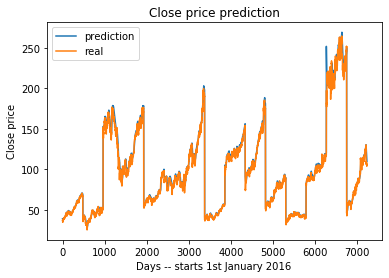

In [66]:
plot_data = []

#hard_pred = []
#to_pred = valid_data[0]

for i in range(len(valid_data)):
    prediction = model.predict(x = np.array([valid_data[i]]), batch_size=1)
    plot_data.append(prediction[0])

    #prediction = model.predict(x = np.array([to_pred]), batch_size=1)
    #hard_pred.append(prediction[0])
    #to_pred = np.roll(to_pred,-1)
    #to_pred[19] = prediction[0]




plt.plot([i for i in range(len(valid_data))], plot_data, label="prediction")
plt.plot([i for i in range(len(valid_data))], res_valid, label="real")
#plt.plot([i for i in range(len(valid_data))], hard_pred, label="hard prediction")
plt.legend()
plt.title("Close price prediction")
plt.xlabel("Days -- starts 1st January 2016 ")
plt.ylabel("Close price")
plt.show()